In [15]:
import sys 
import os

import numpy as np
import pandas as pd
import gym

from tool_functions import initialize_q_table, evaluate_agent

from qlearning import q_learning
from sarsa import sarsa
from every_visit_q_mc import every_visit_mc

### Création et étude de l'environnement

Nous allons entraîner notre agent Q-Learning **à naviguer de l'état de départ (S) à l'état cible (G) en marchant uniquement sur les tuiles gelées (F) et en évitant les trous (H)**.

Nous pouvons avoir deux tailles d'environnement :

- `map_name="4x4"` : une version en grille 4x4
- `map_name="8x8"` : une version en grille 8x8


L'environnement a deux modes :

- `is_slippery=False` : L'agent se déplace toujours **dans la direction prévue** en raison de la nature non glissante du lac gelé (déterministe).
- `is_slippery=True` : L'agent **peut ne pas toujours se déplacer dans la direction voulue** en raison de la nature glissante du lac gelé (stochastique).


Si l'agent **atteint l'objectif** il reçoit une **récompense de 1**, s'il ne **l'atteint pas** (se déplace seulement) il reçoit **0** et s'il **tombe dans un trou** il reçoit également **0**.

In [16]:
# 1er cas : carte 4x4 sans glisse 
env = gym.make(
    'FrozenLake-v1',
    map_name="8x8", 
    is_slippery=False
)

state_space = env.observation_space.n
print("Il y a", state_space, "états possibles")

action_space = env.action_space.n
print("Il y a", action_space, "actions possibles")

# Pour l'évaluation des modèles
eval_env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False
)

Il y a 64 états possibles
Il y a 4 actions possibles


Nous voyons avec `Observation Space Shape Discrete(16)` que l'observation est un entier représentant la **position actuelle de l'agent comme current_row * nrows + current_col (où la row et la col commencent toutes deux à 0)**. 

Par exemple, la position du but dans la carte 4x4 peut être calculée comme suit : 3 * 4 + 3 = 15. Le nombre d'observations possibles dépend de la taille de la carte. **Par exemple, la carte 4x4 a 16 observations possibles.**


Par exemple, voici à quoi ressemble l'état = 0 :

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit2/frozenlake.png" alt="FrozenLake">

In [17]:
# Hyperparamètres partagés par tous les modèles la comparison des modèles

# Entraînement
n_training_episodes = 50000  # Nombre d'épisdoes d'entrainement
max_steps = 1000             # Nombre maximla d'itérations pour un épisode
learning_rate = 0.7         # Taux d'apprentissage (poids accordé au passé pour la mise à jour de la table de Q)
gamma = 0.99

# Exploration 
max_epsilon = 0.8       
min_epsilon = 0.1            
decay_rate = 0.001          # Décroissance exponentielle pour le epsillon considéré par Q de taux decay_rate

# Pour l'affichages des résultats 
res = pd.DataFrame()
smooth = 100 # Lissage des courbes

### Performances d'un estimateur de Monte Carlo Incrémental 

In [18]:
# Obligé de réduire max_steps pour que l'algorithme converge en temps raisonnable 
mc_table = initialize_q_table(state_space, action_space)

mc_table, mc_rewards = every_visit_mc(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=mc_table
)

100%|██████████| 50000/50000 [01:25<00:00, 583.58it/s]


In [19]:
mc_rewards = pd.Series(mc_rewards)
mc_rewards = mc_rewards.rolling(smooth, center=True).mean()
res['IMC-FL'] = mc_rewards

In [20]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=mc_table)

100%|██████████| 100/100 [00:00<00:00, 549.57it/s]


(0.0, 0.0)

### Performances de Q-learning

In [24]:
qlearning_table = initialize_q_table(state_space, action_space)

qlearning_table, rewards = q_learning(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=qlearning_table
)

100%|██████████| 50000/50000 [02:06<00:00, 395.72it/s]


In [25]:
qlearning_rewards = pd.Series(rewards)
qlearning_rewards = qlearning_rewards.rolling(smooth, center=True).mean()
res['qlearning-FL'] = qlearning_rewards

In [26]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=qlearning_table)

100%|██████████| 100/100 [00:00<00:00, 598.33it/s]


(0.0, 0.0)

### Illustrations

In [27]:
import matplotlib.pyplot as plt

<AxesSubplot: >

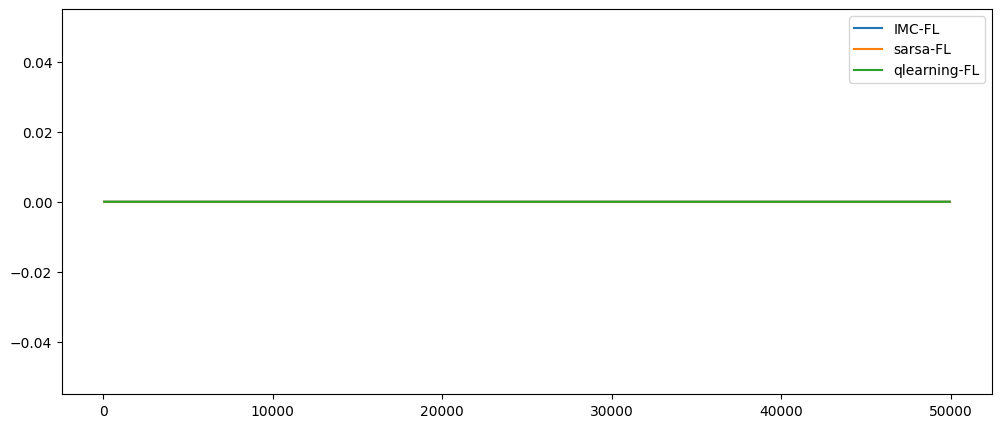

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
res.plot(ax=ax)

In [29]:
res.to_json("hyp_bigfl_config_v1.json")